# Pogo workshop notes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import filters, morphology, measure, color, util
import matplotlib.patches as ptch

## Image manipulation

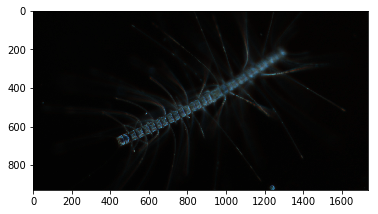

In [2]:
# read image
f = '/home/ec2-user/SageMaker/Notebooks/SPCP2-1515377476-071239-009-36-648-1736-928_rawcolor.jpg'
im = cv2.imread(f)
# and plot it
plt.imshow(im)

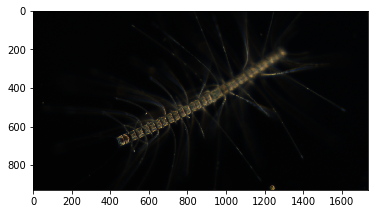

In [3]:
# convert to RGB
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

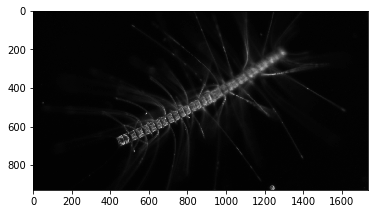

In [4]:
# convert to greyscale
im_grey = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
plt.imshow(im_grey, cmap="gray")

(928, 1736, 3)
(512, 512, 3)


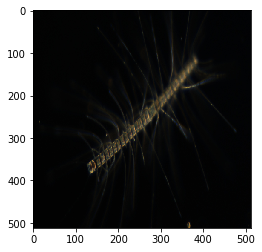

In [5]:
# resize image
print(im.shape)
im_square = cv2.resize(im, dsize=(512,512))
print(im_square.shape)
plt.imshow(im_square)

In [6]:
print(im.shape)
im_square = cv2.resize(im, dsize=None, fx=0.5, fy=0.5)
print(im_square.shape)

(928, 1736, 3)
(464, 868, 3)


In [7]:
# translation
(h,w) = im.shape[0:2]
print(h)
print(w)

928
1736


In [8]:
mm = np.float32([[1, 0, 200], [0, 1, 500]])
mm
# 200: shift image right
# 500: shift image down

array([[  1.,   0., 200.],
       [  0.,   1., 500.]], dtype=float32)

In [17]:
# Define a function to get larger plots
def lplt(ncols=1, figsize=(14,10)):
    fig,axes = plt.subplots(ncols=ncols, figsize=figsize)
    return(axes)

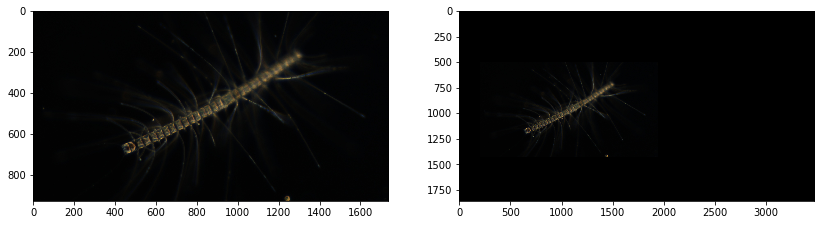

In [18]:
a = lplt(2)
a[0].imshow(im)
a[1].imshow(cv2.warpAffine(im, mm, dsize=(w*2,h*2)))
# enlarge the output image to make sure to see all the object

In [19]:
# rotate
mm = cv2.getRotationMatrix2D((w/2, h/2), 45, 1)
mm

array([[ 7.07106781e-01,  7.07106781e-01, -7.38662325e+01],
       [-7.07106781e-01,  7.07106781e-01,  7.49671140e+02]])

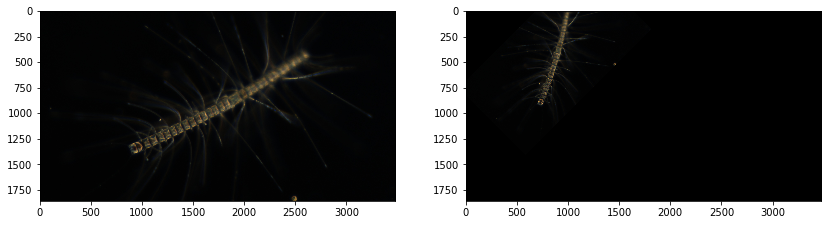

In [20]:
a = lplt(2)
a[0].imshow(cv2.resize(im, dsize=(w*2,h*2)))
a[1].imshow(cv2.warpAffine(im, mm, dsize=(w*2,h*2)))

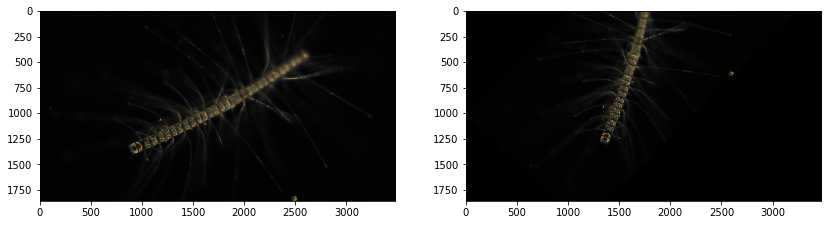

In [21]:
# scale, rotate and shift in one go
mm = np.float32([
    [ 1.2, 1.2,    0],
    [-1.2, 1.2, 1000]]
)
a = lplt(2)
a[0].imshow(cv2.resize(im, dsize=(w*2,h*2)))
a[1].imshow(cv2.warpAffine(im, mm, dsize=(w*2,h*2)))

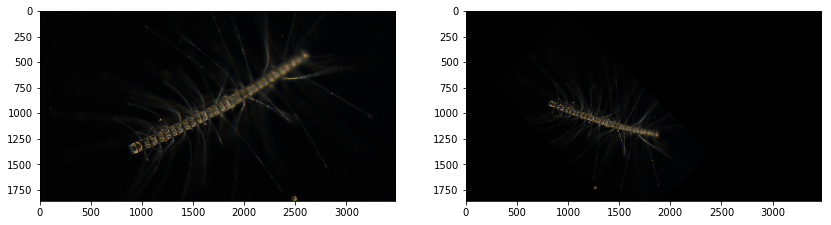

In [22]:
mm = np.float32([
    [0.8, -0.8, 1000],
    [0.8,  0.8, 0]]
)
a = lplt(2)
a[0].imshow(cv2.resize(im, dsize=(w*2,h*2)))
a[1].imshow(cv2.warpAffine(im, mm, dsize=(w*2,h*2)))

In [23]:
# perspective
orig_pts = np.float32([[50, 50], [52, 800], [1500, 42], [1550, 750]])
dest_pts = np.float32([[ 0,  0], [ 0, 750], [1450,  0], [1450, 750]])

mm = cv2.getPerspectiveTransform(orig_pts, dest_pts)
mm

array([[ 9.46603213e-01, -2.52427523e-03, -4.72039469e+01],
       [ 5.71388172e-03,  1.03564106e+00, -5.20677472e+01],
       [-3.69037085e-05,  4.69691142e-05,  1.00000000e+00]])

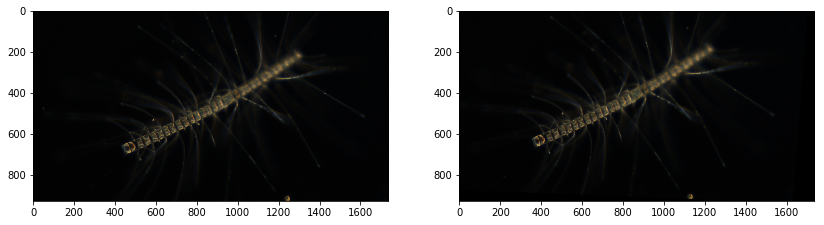

In [24]:
a = lplt(2)
a[0].imshow(cv2.resize(im, dsize=(w,h)))
a[1].imshow(cv2.warpPerspective(im, mm, dsize=(w,h)))

## Segmentation

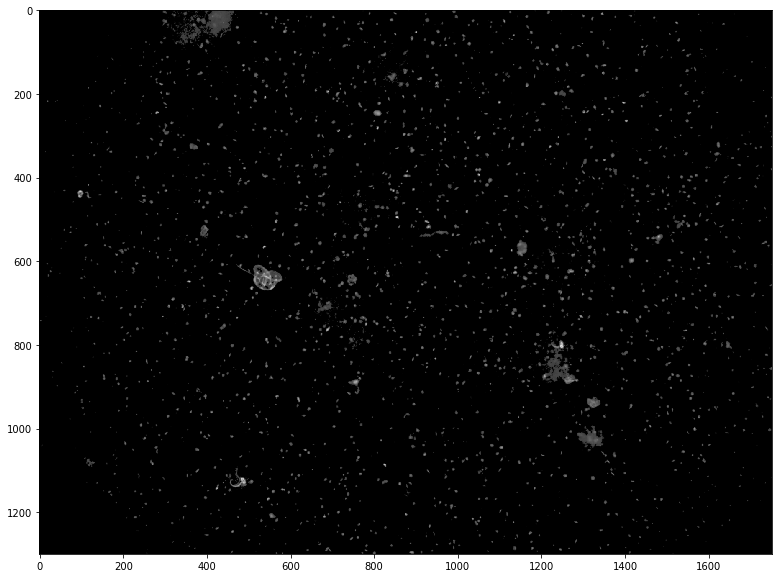

In [25]:
# read image
f = '/home/ec2-user/SageMaker/Notebooks/SHRINK-SPC-UW-1501200429144329-32334591114-000055.png'
im = cv2.imread(f)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
# and plot it
lplt().imshow(im, cmap='gray')

### Thresholding

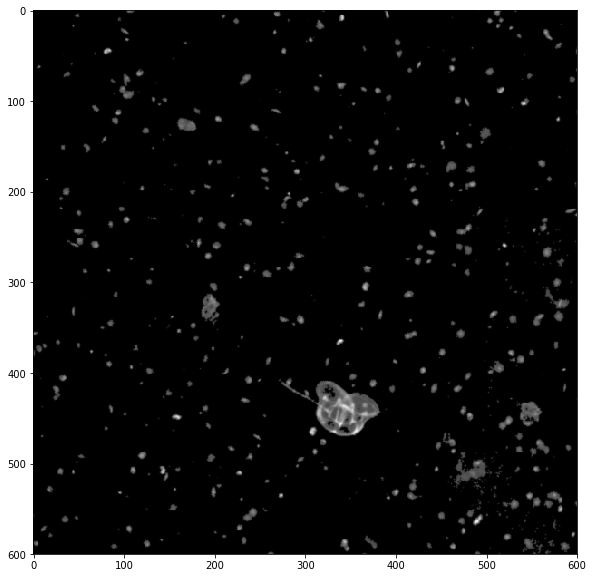

In [26]:
# take a smaller crop
im_s = im[200:800,200:800]
lplt().imshow(im_s, cmap='gray')

In [27]:
# get a decent threhsold estimate
np.mean(im)

2.619022655426765

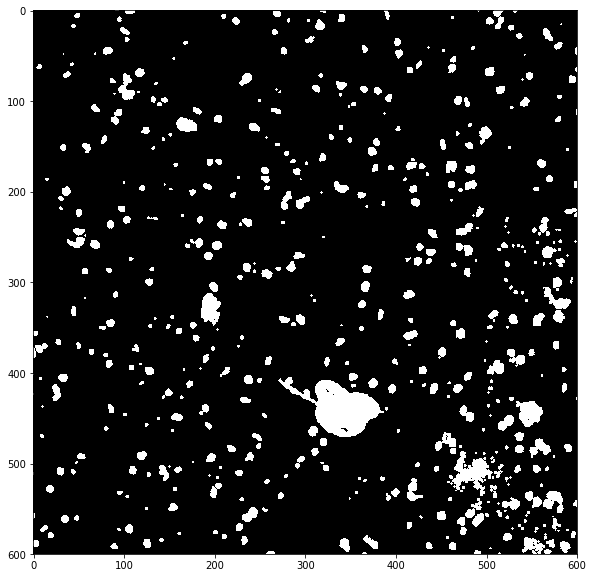

In [28]:
# and treshold
im_t = np.where(im_s < 2, 0., 1.)
lplt().imshow(im_t, cmap='gray')

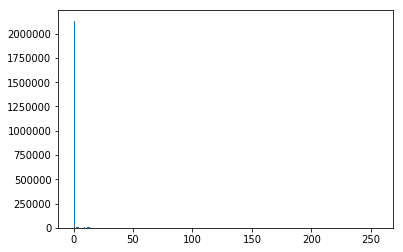

In [29]:
# get a better estimate from the histogram
plt.hist(im.ravel(), 256, [0, 256]) # 256 bins
plt.show()

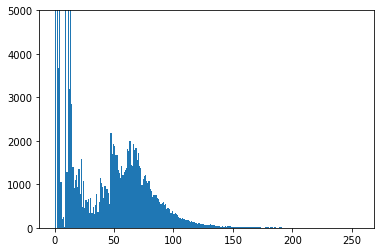

In [30]:
# zoom in on the intensity plot
plt.hist(im.ravel(), 256, [0, 256])
plt.ylim([0, 5000])
plt.show()

Otsu threshold:  34


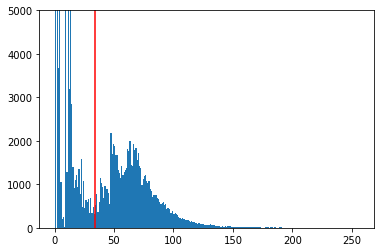

In [31]:
# use Otsu's thresholding method
# (find the optimal difference between the two modes)
otsu = filters.thresholding.threshold_otsu(im)
print("Otsu threshold: ", str(otsu))
# and plot it
plt.hist(im.ravel(), 256, [0, 256])
plt.ylim([0, 5000])
plt.axvline(x=otsu, color='red')
plt.show()

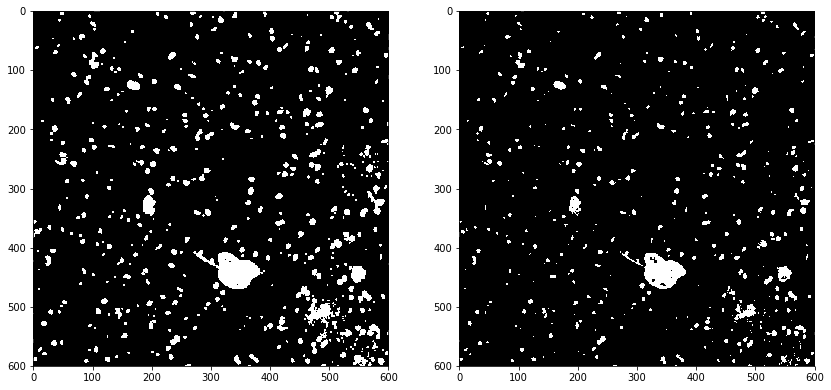

In [35]:
# and treshold
im_ot = np.where(im_s < otsu, 0., 1.)
a=lplt(2)
a[0].imshow(im_t, cmap='gray')
a[1].imshow(im_ot, cmap='gray')

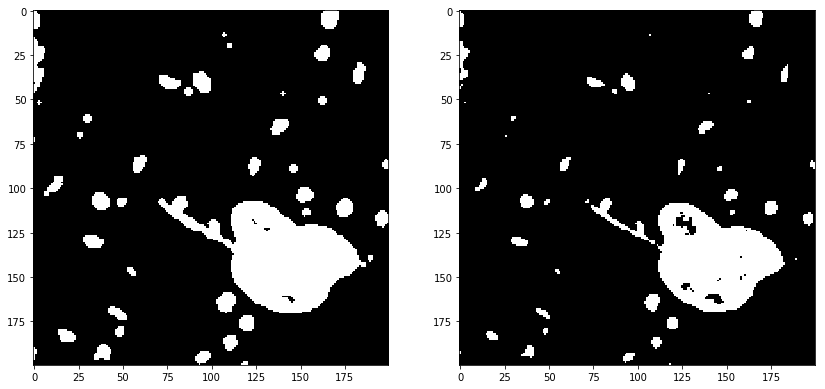

In [36]:
a=lplt(2)
a[0].imshow(im_t[300:500,200:400], cmap='gray')
a[1].imshow(im_ot[300:500,200:400], cmap='gray')
# better

### Filtering

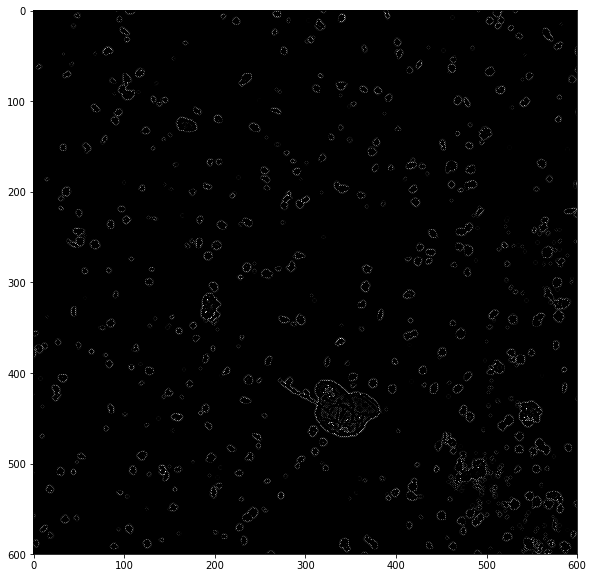

In [37]:
# edge detection through second derivative
im_lp = cv2.Laplacian(im_s,
                      cv2.CV_16UC1, # swicth to 16bit compute for precision
                      ksize=1       # defines kernel shape
                     )
lplt().imshow(im_lp, cmap='gray')

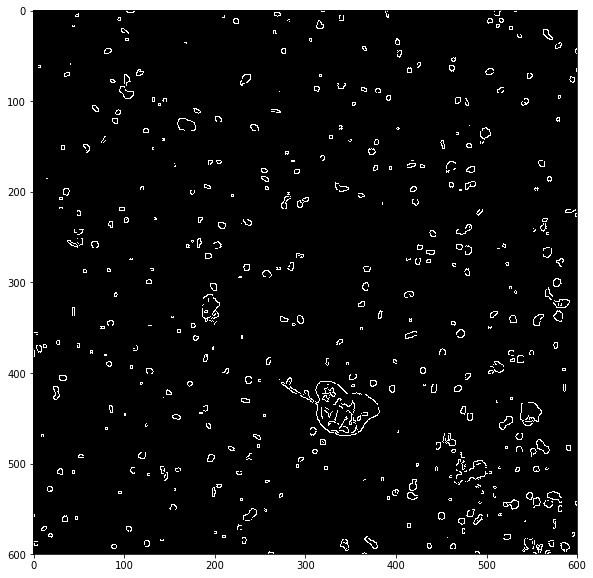

In [38]:
# Canny edge detector
im_ca = cv2.Canny(im_s, threshold1=150, threshold2=225)
lplt().imshow(im_ca, cmap='gray')

### Extracting objects

In [39]:
morphology.square(5)

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

In [40]:
morphology.disk(5)

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], dtype=uint8)

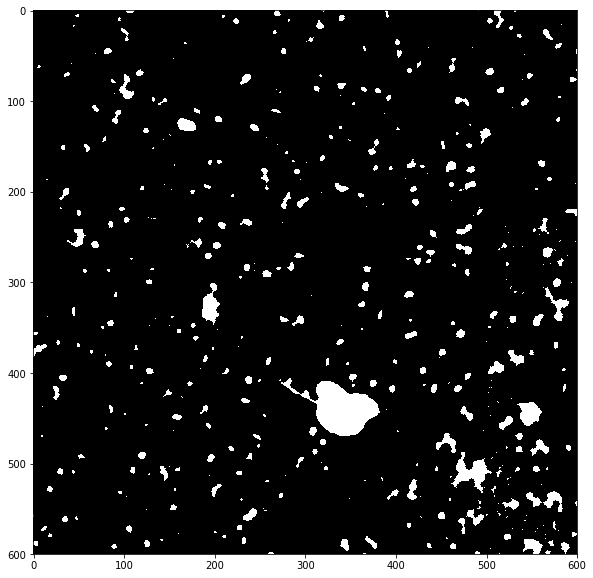

In [41]:
im_close = morphology.closing(im_ot, morphology.disk(3))
# NB: appropriate when objects are approx the same size
lplt().imshow(im_close, cmap='gray')

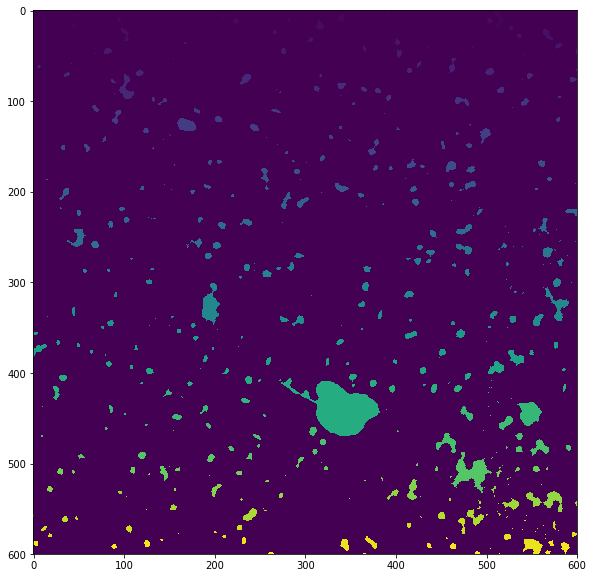

In [42]:
im_label = morphology.label(im_close, neighbors=8, background=0)
lplt().imshow(im_label)

In [43]:
# measure all detected objects
props = measure.regionprops(im_label, im_s, ['Area', 'BoundingBox'])
len(props)

461

In [44]:
# keep only the large ones
props_large = [p for p in props if p.area > 200]
len(props_large)

10

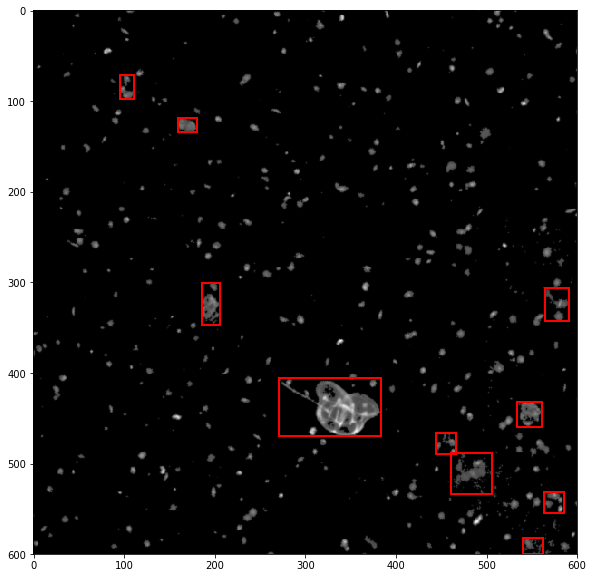

In [46]:
# plot them
a = lplt()
a.imshow(im_s, cmap = 'gray')
for p in props_large:
    rect = ptch.Rectangle((p.bbox[1], p.bbox[0]),
                          p.bbox[3] - p.bbox[1], p.bbox[2] - p.bbox[0],
                          fill=False, edgecolor='red', linewidth=2)

    a.add_patch(rect)

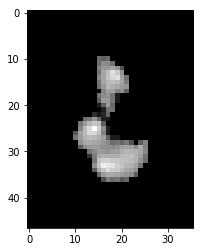

In [47]:
# get each large particle, dilate it a bit and paste it on a pure black background



part = 
part = util.pad(part, pad_width=10, mode='constant', constant_values=0)
plt.imshow(part, cmap='gray')

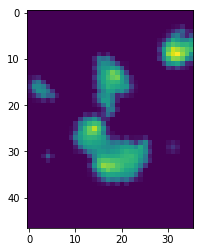

In [302]:
x = np.array(props_large[0].bbox) + [-10,-10,10,10]





plt.imshow(im_s[x[0]:x[2], x[1]:x[3]])

